In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC

from ucimlrepo import fetch_ucirepo

In [2]:
# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features

# metadata
# print(mushroom.metadata)

# # variable information
# print(mushroom.variables)

# print(f"Original number of features: {X.shape[1]}")
# print("Columns unique features:")
# print(X.nunique())
# print("Columns with missing values: (%)")
# print(X.isna().mean() * 100)

In [3]:
expanded_cols = []
X_numeric_pd = X.copy()
for col in X.columns:
    X_numeric_pd[col] = X_numeric_pd[col].astype("category").cat.codes
    # if there is nan in this column, replace it with max + 1
    if X[col].isna().sum() > 0:
        X_numeric_pd[col] = X_numeric_pd[col].replace(
            -1, max(X_numeric_pd[col]) + 1
        )
        expanded_cols.append(col)

# X_numeric_pd

In [4]:
for e in expanded_cols:
    print(f"Column {e} had NaN.\nNow the unique values are: ")
    print(X_numeric_pd[e].unique())

    # check the frequency of each value in the column, including NaN
    print(f"Frequency of each value in the column: ")
    print(X_numeric_pd["stalk-root"].value_counts(dropna=False))

    print("The categories are: ")
    print(X[e].astype("category").cat.categories)

Column stalk-root had NaN.
Now the unique values are: 
[2 1 0 3 4]
Frequency of each value in the column: 
stalk-root
0    3776
4    2480
2    1120
1     556
3     192
Name: count, dtype: int64
The categories are: 
Index(['b', 'c', 'e', 'r'], dtype='object')


In [5]:
def custom_combiner(feature, category):
    # print(f"feature: {feature}")
    # print(f"category: {category}")
    if feature == "feature":
        return "test"
    feature_og_name_dict = dict(
        enumerate(X[feature].astype("category").cat.categories)
    )
    if feature in expanded_cols and category not in feature_og_name_dict:
        return f"{feature}=nan"
    return f"{feature}={feature_og_name_dict[category]}"


ohe = OneHotEncoder(drop="if_binary", feature_name_combiner=custom_combiner)
X_oh_np = ohe.fit_transform(X_numeric_pd.to_numpy()).toarray()
feature_names = ohe.get_feature_names_out(
    input_features=X_numeric_pd.columns.to_list()
)

print(X_oh_np.shape)
print(feature_names)


y_np = np.where(mushroom.data.targets.to_numpy() == "p", 1, 0).flatten()
print(y_np.shape)

(8124, 112)
['cap-shape=b' 'cap-shape=c' 'cap-shape=f' 'cap-shape=k' 'cap-shape=s'
 'cap-shape=x' 'cap-surface=f' 'cap-surface=g' 'cap-surface=s'
 'cap-surface=y' 'cap-color=b' 'cap-color=c' 'cap-color=e' 'cap-color=g'
 'cap-color=n' 'cap-color=p' 'cap-color=r' 'cap-color=u' 'cap-color=w'
 'cap-color=y' 'bruises=t' 'odor=a' 'odor=c' 'odor=f' 'odor=l' 'odor=m'
 'odor=n' 'odor=p' 'odor=s' 'odor=y' 'gill-attachment=f' 'gill-spacing=w'
 'gill-size=n' 'gill-color=b' 'gill-color=e' 'gill-color=g' 'gill-color=h'
 'gill-color=k' 'gill-color=n' 'gill-color=o' 'gill-color=p'
 'gill-color=r' 'gill-color=u' 'gill-color=w' 'gill-color=y'
 'stalk-shape=t' 'stalk-root=b' 'stalk-root=c' 'stalk-root=e'
 'stalk-root=r' 'stalk-root=nan' 'stalk-surface-above-ring=f'
 'stalk-surface-above-ring=k' 'stalk-surface-above-ring=s'
 'stalk-surface-above-ring=y' 'stalk-surface-below-ring=f'
 'stalk-surface-below-ring=k' 'stalk-surface-below-ring=s'
 'stalk-surface-below-ring=y' 'stalk-color-above-ring=b'
 'stalk-c

In [6]:
train_X, hold_out_test_X, train_y, hold_out_test_y = train_test_split(
    X_oh_np, y_np, test_size=0.2, random_state=73, stratify=y_np
)

In [7]:
train_y.mean(), hold_out_test_y.mean()

(0.4820741652561933, 0.48184615384615387)

In [8]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [9]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

In [10]:
def binary_classification(
    model,
    model_name: str,
    n_splits: int = NUM_FOLD,
    random_state: int = RANDOM_STATE,
):
    print(f"Model {model_name} with {n_splits}-fold cross-validation\n")
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state
    )

    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_mcc = []

    hold_out_accuracy = []
    hold_out_precision = []
    hold_out_recall = []
    hold_out_f1 = []
    hold_out_mcc = []

    fig, ax = plt.subplots(1, 5, figsize=(15, 4))
    for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
        model.fit(train_X[train_index], train_y[train_index])

        y_pred = model.predict(train_X[test_index])

        acc = accuracy_score(train_y[test_index], y_pred)
        prec = precision_score(train_y[test_index], y_pred, zero_division=0)
        rec = recall_score(train_y[test_index], y_pred)
        f1 = f1_score(train_y[test_index], y_pred)
        mcc = matthews_corrcoef(train_y[test_index], y_pred)
        fold_accuracy.append(acc)
        fold_precision.append(prec)
        fold_recall.append(rec)
        fold_f1.append(f1)
        fold_mcc.append(mcc)
        print(
            f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
            f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
        )

        # Test on hold-out test set
        y_hold_out_pred = model.predict(hold_out_test_X)

        acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
        prec = precision_score(hold_out_test_y, y_hold_out_pred, zero_division=0)
        rec = recall_score(hold_out_test_y, y_hold_out_pred)
        f1 = f1_score(hold_out_test_y, y_hold_out_pred)
        mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
        hold_out_accuracy.append(acc)
        hold_out_precision.append(prec)
        hold_out_recall.append(rec)
        hold_out_f1.append(f1)
        hold_out_mcc.append(mcc)
        print(
            f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
            f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
        )

        # Plot confusion matrix
        cm = confusion_matrix(train_y[test_index], y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm, display_labels=model.classes_
        )
        disp.plot(ax=ax[i], xticks_rotation=45)
        ax[i].set_title(f"Fold {i}")

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
    print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
    print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
    print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
    print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

    print("\nHold-out Test Results:")
    print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
    print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
    print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
    print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
    print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")

    plt.tight_layout()

## Logistic regression

Model Logistic Regression with 5-fold cross-validation

Fold 0: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 1: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 2: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=0.9994, Precision=1.0000, Recall=0.9987, F1=0.9994, MCC=0.9988
Fold 3: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=0.9994, Precision=1.0000, Recall=0.9987, F1=0.9994, MCC=0.9988
Fold 4: Accuracy=0.9992, Precision=1.0000, Recall=0.9984, F1=0.9992, MCC=0.9985
Hold-out Test: Accuracy=0.9994, Precision=1.0000, Recall=0.9987, F1=0.9994, MCC=0.9988

Cross-Validation Results:
Mean Accuracy: 1.000 ± 0.000
Mean Precision: 1.000 ± 0.000
Mean Recall: 1.000 ± 0.

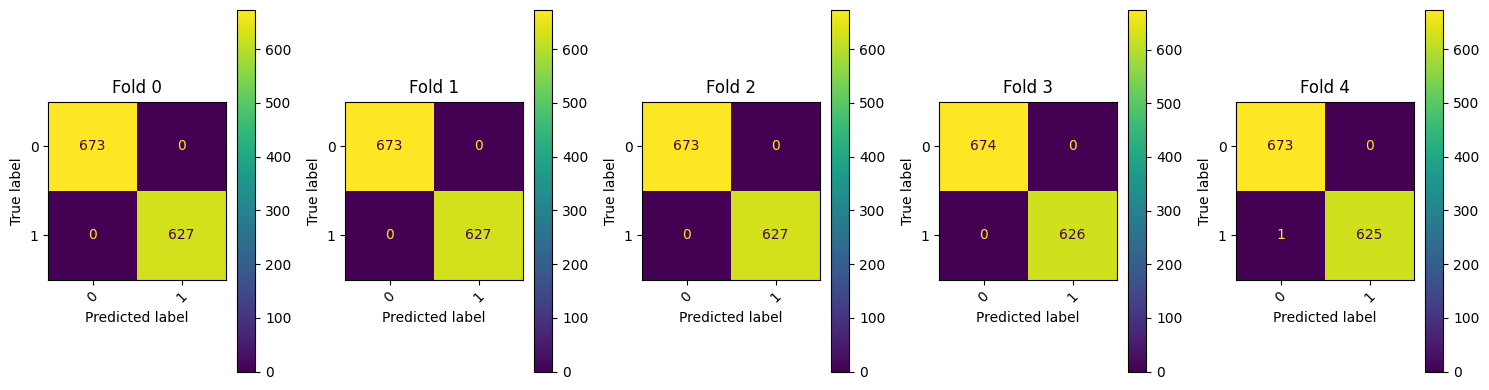

In [11]:
model = LogisticRegression(solver="liblinear")
binary_classification(model, "Logistic Regression")

## Random forest

Model Random Forest with 5-fold cross-validation

Fold 0: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 1: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 2: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 3: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 4: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000

Cross-Validation Results:
Mean Accuracy: 1.000 ± 0.000
Mean Precision: 1.000 ± 0.000
Mean Recall: 1.000 ± 0.000
Me

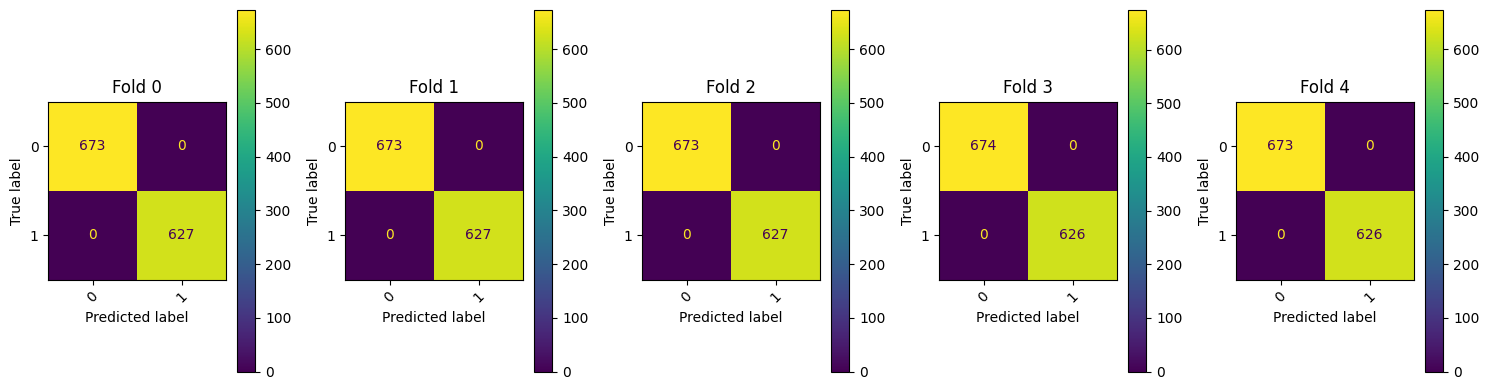

In [12]:
model = RandomForestClassifier(n_estimators=100, random_state=75)
binary_classification(model, "Random Forest")

## SVM

Model SVM with 5-fold cross-validation

Fold 0: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 1: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 2: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 3: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 4: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000

Cross-Validation Results:
Mean Accuracy: 1.000 ± 0.000
Mean Precision: 1.000 ± 0.000
Mean Recall: 1.000 ± 0.000
Mean F1 Scor

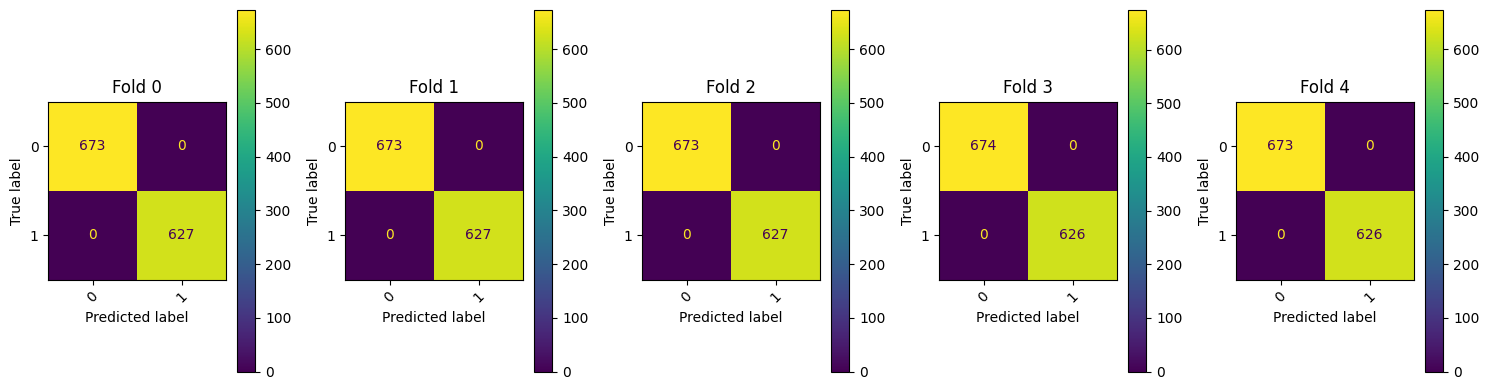

In [13]:
model = SVC(kernel="rbf", random_state=76, class_weight="balanced")
binary_classification(model, "SVM")

## Decision tree

Model Decision Tree with 5-fold cross-validation

Fold 0: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 1: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 2: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 3: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Hold-out Test: Accuracy=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000, MCC=1.0000
Fold 4: Accuracy=0.9992, Precision=1.0000, Recall=0.9984, F1=0.9992, MCC=0.9985
Hold-out Test: Accuracy=0.9994, Precision=1.0000, Recall=0.9987, F1=0.9994, MCC=0.9988

Cross-Validation Results:
Mean Accuracy: 1.000 ± 0.000
Mean Precision: 1.000 ± 0.000
Mean Recall: 1.000 ± 0.000
Me

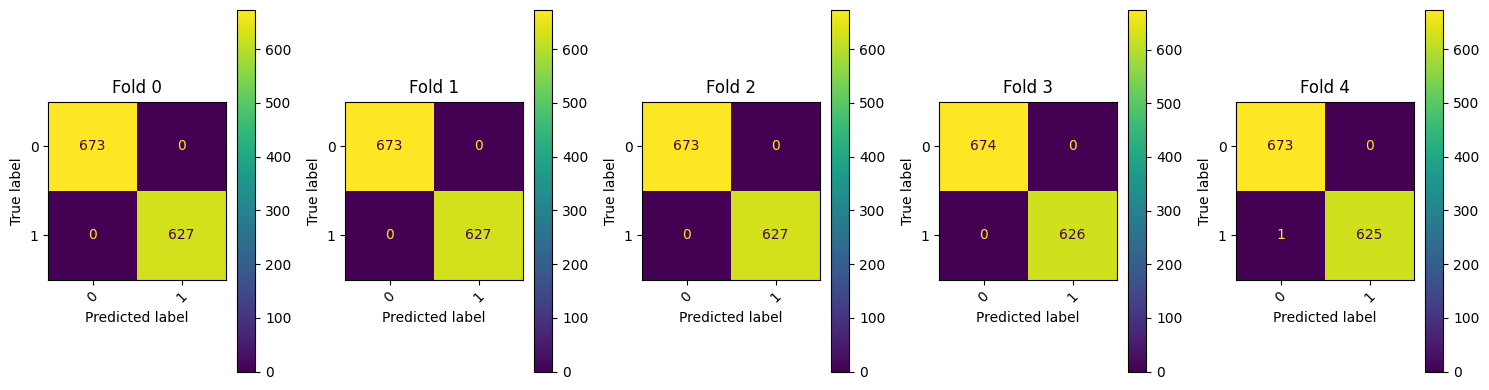

In [14]:
model = DecisionTreeClassifier(random_state=77, class_weight="balanced")
binary_classification(model, "Decision Tree")

In [15]:
# show the max depth of the decision tree
model.get_depth()

8

[Text(0.5789473684210527, 0.9444444444444444, 'odor=n <= 0.5\ngini = 0.5\nsamples = 5200\nvalue = [2600.0, 2600.0]'),
 Text(0.3157894736842105, 0.8333333333333334, 'stalk-root=c <= 0.5\ngini = 0.271\nsamples = 2926\nvalue = [485.629, 2512.884]'),
 Text(0.4473684210526316, 0.8888888888888888, 'True  '),
 Text(0.21052631578947367, 0.7222222222222222, 'stalk-root=r <= 0.5\ngini = 0.123\nsamples = 2583\nvalue = [174.749, 2491.105]'),
 Text(0.15789473684210525, 0.6111111111111112, 'odor=a <= 0.5\ngini = 0.047\nsamples = 2466\nvalue = [61.79, 2491.105]'),
 Text(0.10526315789473684, 0.5, 'odor=l <= 0.5\ngini = 0.023\nsamples = 2432\nvalue = [28.964, 2491.105]'),
 Text(0.05263157894736842, 0.3888888888888889, 'gini = -0.0\nsamples = 2402\nvalue = [0.0, 2491.105]'),
 Text(0.15789473684210525, 0.3888888888888889, 'gini = -0.0\nsamples = 30\nvalue = [28.964, 0.0]'),
 Text(0.21052631578947367, 0.5, 'gini = -0.0\nsamples = 34\nvalue = [32.826, 0.0]'),
 Text(0.2631578947368421, 0.6111111111111112, '

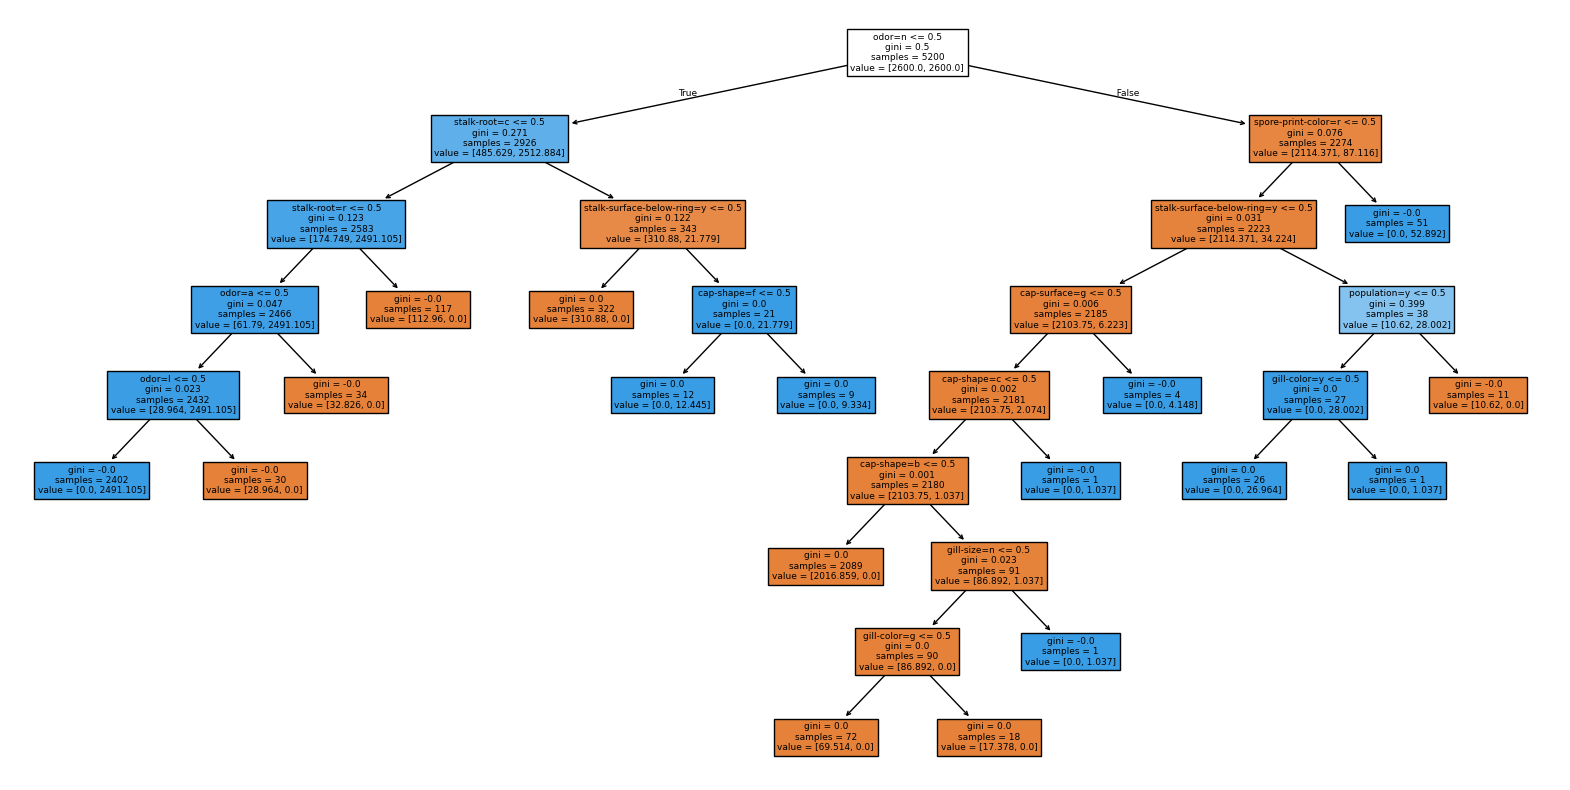

In [16]:
# display the decision tree
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=feature_names)